# **(Modelling and Evaluation)**

## Objectives

* Fit and evaluate a regression model to predict House sale prices for Lydias inherited houses and other houses in the Ames, Iowa area.
    -   Business Requirement 2

## Inputs

* outputs/datasets/collection/original_no_nan.csv 

## Outputs

* Train set (features and target)
* Test set (features and target)
* ML pipeline to predict house sale price

---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/milestone-project-heritage-housing-issues/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/milestone-project-heritage-housing-issues'

## Load Data

In [4]:
import pandas as pd
import numpy as np

df = (pd.read_csv(f"outputs/datasets/collection/original_no_nan.csv")
    .drop(labels=['EnclosedPorch', 'WoodDeckSF'], axis=1)
    )
df.head(5)

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854,3,No,706,GLQ,150,548,RFn,2003.0,...,8450,65.0,196.0,61,5,7,856,2003,2003,208500
1,1262,0,3,Gd,978,ALQ,284,460,RFn,1976.0,...,9600,80.0,0.0,0,8,6,1262,1976,1976,181500
2,920,866,3,Mn,486,GLQ,434,608,RFn,2001.0,...,11250,68.0,162.0,42,5,7,920,2001,2002,223500
3,961,0,0,No,216,ALQ,540,642,Unf,1998.0,...,9550,60.0,0.0,35,5,7,756,1915,1970,140000
4,1145,0,4,Av,655,GLQ,490,836,RFn,2000.0,...,14260,84.0,350.0,84,5,8,1145,2000,2000,250000


---

In [5]:
print(df.info())
print(df.columns.to_list())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   1stFlrSF      1460 non-null   int64  
 1   2ndFlrSF      1460 non-null   int64  
 2   BedroomAbvGr  1460 non-null   int64  
 3   BsmtExposure  1460 non-null   object 
 4   BsmtFinSF1    1460 non-null   int64  
 5   BsmtFinType1  1460 non-null   object 
 6   BsmtUnfSF     1460 non-null   int64  
 7   GarageArea    1460 non-null   int64  
 8   GarageFinish  1460 non-null   object 
 9   GarageYrBlt   1460 non-null   float64
 10  GrLivArea     1460 non-null   int64  
 11  KitchenQual   1460 non-null   object 
 12  LotArea       1460 non-null   int64  
 13  LotFrontage   1460 non-null   float64
 14  MasVnrArea    1460 non-null   float64
 15  OpenPorchSF   1460 non-null   int64  
 16  OverallCond   1460 non-null   int64  
 17  OverallQual   1460 non-null   int64  
 18  TotalBsmtSF   1460 non-null 

# ML Regressor Pipeline


#### Create the Pipeline


In [6]:
from sklearn.pipeline import Pipeline

# Feature Engineering
from feature_engine.encoding import OrdinalEncoder
from feature_engine.selection import SmartCorrelatedSelection
from feature_engine.transformation import LogTransformer, PowerTransformer
from feature_engine.outliers import OutlierTrimmer

# Feat Scaling
from sklearn.preprocessing import StandardScaler

# Feat Selection
from sklearn.feature_selection import SelectFromModel

# ML algorithms
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor

def PipelineOptimization(model):
    pipeline_base = Pipeline([

        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual'])),

        ('log_10_transformer', LogTransformer(variables=['1stFlrSF', 'GrLivArea', 'LotArea', 'LotFrontage'], base='10')),

        ("power_transformer", PowerTransformer(variables=['BedroomAbvGr', 'BsmtUnfSF', 'GarageArea', 'TotalBsmtSF'], exp=0.5)),

        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="pearson", threshold=0.7, selection_method="variance")),

        ("feat_scaling", StandardScaler()),

        ("feat_selection",  SelectFromModel(model)),

        ("model", model),

    ])

    return pipeline_base


/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


#### Load Custom Class for Hyperparameter Optimisation

In [7]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model = PipelineOptimization(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches

## Split Train Test Set

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['SalePrice'], axis=1),
    df['SalePrice'],
    test_size=0.2,
    random_state=0
)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)

print(X_train.head(3))

* Train set: (1168, 21) (1168,) 
* Test set: (292, 21) (292,)
     1stFlrSF  2ndFlrSF  BedroomAbvGr BsmtExposure  BsmtFinSF1 BsmtFinType1  \
618      1828         0             0           Av          48         None   
870       894         0             2           No           0          Unf   
92        964         0             2           No         713          ALQ   

     BsmtUnfSF  GarageArea GarageFinish  GarageYrBlt  ...  KitchenQual  \
618       1774         774          Unf       2007.0  ...           Gd   
870        894         308         None       1962.0  ...           TA   
92         163         432          Unf       1921.0  ...           TA   

    LotArea  LotFrontage  MasVnrArea  OpenPorchSF  OverallCond  OverallQual  \
618   11694         90.0       452.0          108            5            9   
870    6600         60.0         0.0            0            5            5   
92    13360         80.0         0.0            0            7            5   

     To

---

#### Using HyperparameterOptimizationSearch class to assess algorithm suitability.

In [9]:
models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

#### Default Hyper Parameter Search

In [10]:
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.In

#### Default Hyper Parameter Search Results

In [11]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
0,LinearRegression,0.735427,0.809722,0.854261,0.044392
3,ExtraTreesRegressor,0.697044,0.804563,0.860545,0.057167
5,GradientBoostingRegressor,0.635793,0.768876,0.831192,0.070259
4,AdaBoostRegressor,0.648687,0.754101,0.813391,0.05567
2,RandomForestRegressor,0.630557,0.71583,0.817727,0.071702
6,XGBRegressor,0.516448,0.650623,0.751455,0.087641
1,DecisionTreeRegressor,0.488006,0.571741,0.667303,0.071561


##### Linear Regression is the top performer above:

- LinearRegression:	min_score: 0.735427	| mean_score  0.809722 | max_score  0.854261 | std_score  0.044392

- Parsing an empty dictionary for linear regression below:

In [12]:
models_search = {
    "LinearRegression": LinearRegression(),
}

params_search = {
    "LinearRegression": {}
}

In [13]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa

In [14]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
0,LinearRegression,0.735427,0.809722,0.854261,0.044392


In [15]:
best_model = grid_search_summary.iloc[0, 0]
best_model

'LinearRegression'

In [16]:
grid_search_pipelines[best_model].best_params_

{}

- Best pipeline for Linear Regression:

In [17]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['BsmtExposure', 'BsmtFinType1',
                                           'GarageFinish', 'KitchenQual'])),
                ('log_10_transformer',
                 LogTransformer(base='10',
                                variables=['1stFlrSF', 'GrLivArea', 'LotArea',
                                           'LotFrontage'])),
                ('power_transformer',
                 PowerTransformer(variables=['BedroomAbvGr', 'BsmtUnfSF',
                                             'Gara...
                                                     'BsmtFinSF1',
                                                     'BsmtFinType1',
                                                     'BsmtUnfSF', 'GarageArea',
                                                     'GarageFinish',
                                                     'GarageYrBlt', 

## Assess Feature Importance

* These are the 9 most important features in descending order. The model was trained on them: 
['1stFlrSF', '2ndFlrSF', 'BsmtFinSF1', 'KitchenQual', 'LotArea', 'MasVnrArea', 'OverallQual', 'YearBuilt', 'YearRemodAdd']


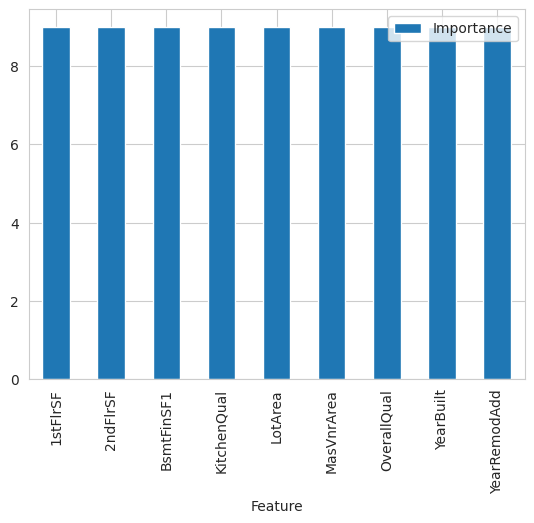

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# after data cleaning and feature engineering, the features may have changes
# how many data cleaning and feature engineering steps does your pipeline have?
data_cleaning_feat_eng_steps = 4
columns_after_data_cleaning_feat_eng = (Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support(
)].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()],
    'Importance': best_regressor_pipeline['model'].n_features_in_})
    .sort_values(by='Importance', ascending=False)
)

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

## Evaluate on Train and Test Sets

In [19]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np


def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    print("Model Evaluation \n")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline)


def regression_evaluation(X, y, pipeline):
    prediction = pipeline.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))
    print('Root Mean Squared Error:', np.sqrt(
        mean_squared_error(y, prediction)).round(3))
    print("\n")


def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")

    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")

    plt.show()

Model Evaluation 

* Train Set
R2 Score: 0.821
Mean Absolute Error: 22229.351
Mean Squared Error: 1104802160.273
Root Mean Squared Error: 33238.564


* Test Set
R2 Score: 0.7
Mean Absolute Error: 25340.502
Mean Squared Error: 2074923405.215
Root Mean Squared Error: 45551.327




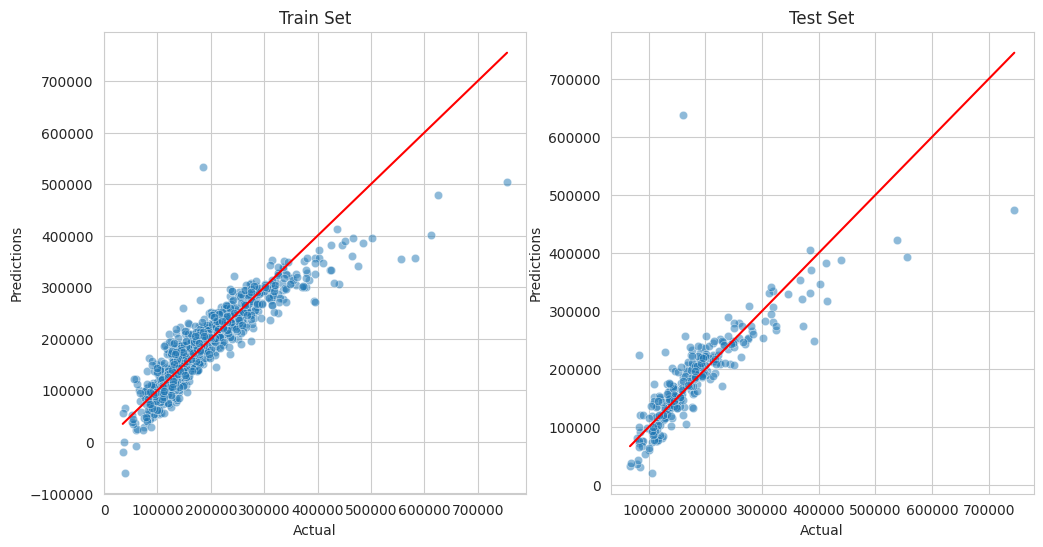

In [20]:
regression_performance(X_train, y_train, X_test, y_test, best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

**I am not entirely happy with the error values here(Test set performing worse), and drop in R2 Score from 0.821 on the Train set to 0.7 on the test set.**

- Even though the plots are reasonably ok, with outliers in similar areas on the plots, I will see if PCA can improve the results.

- PCA will see which features in the data explain most of the variance, and hopefully reduce the dataset to a few components.

In [21]:
pipeline = PipelineOptimization(model=LinearRegression())
pipeline_pca = Pipeline(pipeline.steps[:3])
df_pca = pipeline_pca.fit_transform(df.drop(['SalePrice'], axis=1))

print(df_pca.shape,'\n', type(df_pca))


(1460, 21) 
 <class 'pandas.core.frame.DataFrame'>


* The 20 components explain 100.0% of the data 



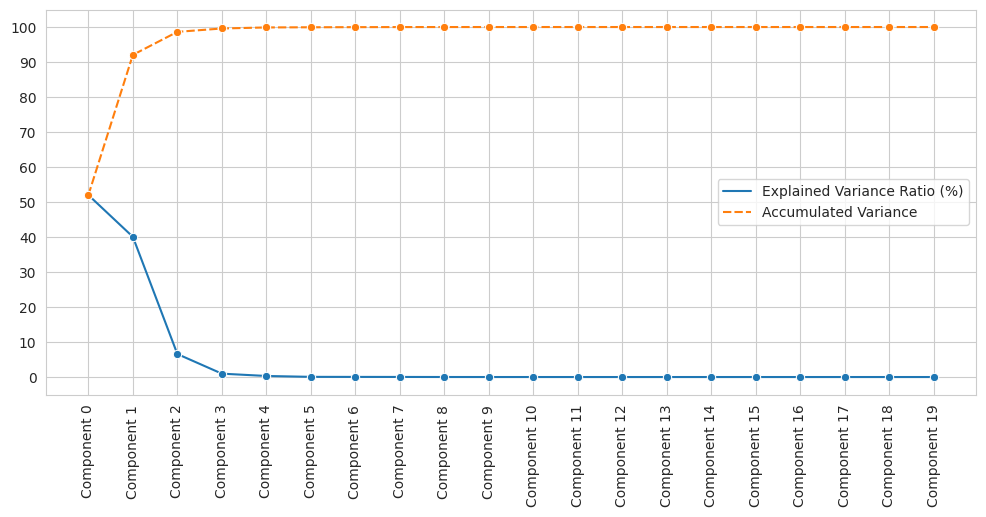

In [22]:
import numpy as np
from sklearn.decomposition import PCA

n_components = 20


def pca_components_analysis(df_pca, n_components):
    pca = PCA(n_components=n_components).fit(df_pca)
    x_PCA = pca.transform(df_pca)  # array with transformed PCA

    ComponentsList = ["Component " + str(number)
                      for number in range(n_components)]
    dfExplVarRatio = pd.DataFrame(
        data=np.round(100 * pca.explained_variance_ratio_, 3),
        index=ComponentsList,
        columns=['Explained Variance Ratio (%)'])

    dfExplVarRatio['Accumulated Variance'] = dfExplVarRatio['Explained Variance Ratio (%)'].cumsum(
    )

    PercentageOfDataExplained = dfExplVarRatio['Explained Variance Ratio (%)'].sum(
    )

    print(
        f"* The {n_components} components explain {round(PercentageOfDataExplained,2)}% of the data \n")
    plt.figure(figsize=(12, 5))
    sns.lineplot(data=dfExplVarRatio,  marker="o")
    plt.xticks(rotation=90)
    plt.yticks(np.arange(0, 110, 10))
    plt.show()


pca_components_analysis(df_pca=df_pca, n_components=n_components)

* The 2 components explain 92.05% of the data 



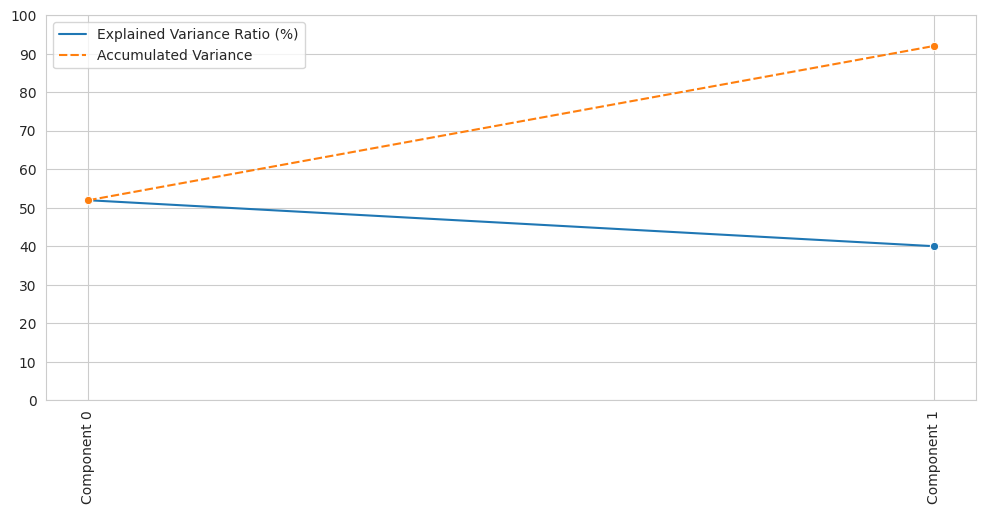

In [23]:
n_components = 2
pca_components_analysis(df_pca=df_pca, n_components=n_components)

- This is a good result. The PCA analysis has managed to explain 92.05% of the data using only 2 components.

## Rewrite Pipeline using PCA

- 'feat_selection' removed in this pipeline and replaced with 'PCA'.

In [24]:
from sklearn.decomposition import PCA


def PipelineOptimization(model):
    pipeline_base = Pipeline([

        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual'])),                                             

        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="pearson", threshold=0.7, selection_method="variance")),

        ("feat_scaling", StandardScaler()),

        ("PCA", PCA(n_components=2, random_state=0)),

        ("model", model),

    ])

    return pipeline_base


In [25]:
print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (1168, 21) (1168,) 
* Test set: (292, 21) (292,)


#### Using HyperparameterOptimizationSearch class to assess algorithm suitability for the pipepine containing PCA.

In [26]:
models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

#### Run a new optimization search on the PCA pipline

In [27]:
quick_search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
quick_search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa


Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/workspace/.pip-modules/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.In

In [28]:
grid_search_summary, grid_search_pipelines = quick_search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
5,GradientBoostingRegressor,0.600626,0.78103,0.836262,0.090918
2,RandomForestRegressor,0.674552,0.780128,0.816755,0.053665
0,LinearRegression,0.680286,0.757822,0.795746,0.044372
3,ExtraTreesRegressor,0.560059,0.748247,0.806616,0.094757
6,XGBRegressor,0.553852,0.73646,0.805889,0.092546
4,AdaBoostRegressor,0.63173,0.727845,0.799957,0.063101
1,DecisionTreeRegressor,0.428575,0.632137,0.702345,0.102869


#### GradientBoostingRegressor is the top performer above:

- GradientBoostingRegressor:	min_score: 0.600626		| mean_score  0.78103 | max_score  0.836262 | std_score  0.090918

In [29]:

models_search = {
    "GradientBoostingRegressor":GradientBoostingRegressor(random_state=0),
}

params_search = {
    "GradientBoostingRegressor":{'model__n_estimators': [100,50,140],
                                  'model__learning_rate':[0.1, 0.01, 0.001],
                                  'model__max_depth': [3,15, None],
                                  'model__min_samples_split': [2,50],
                                  'model__min_samples_leaf': [1,50],
                                  'model__max_leaf_nodes': [None,50],
                            }
  }

Explain these hyperparameters and try to alter and adjust and take screenshots of before and after


In [30]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/workspace/.pip-modules/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWa

- **New hyperparameters have improved the results for GradientBoostingRegressor**

In [31]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__learning_rate,model__max_depth,model__max_leaf_nodes,model__min_samples_leaf,model__min_samples_split,model__n_estimators
4,GradientBoostingRegressor,0.618754,0.789205,0.848326,0.085848,0.1,3,None,1,50,50
16,GradientBoostingRegressor,0.618754,0.789205,0.848326,0.085848,0.1,3,50,1,50,50
1,GradientBoostingRegressor,0.626906,0.787848,0.841091,0.081355,0.1,3,None,1,2,50
13,GradientBoostingRegressor,0.626906,0.787827,0.841091,0.081353,0.1,3,50,1,2,50
10,GradientBoostingRegressor,0.729121,0.786154,0.827756,0.042499,0.1,3,None,50,50,50
...,...,...,...,...,...,...,...,...,...,...,...
187,GradientBoostingRegressor,0.049656,0.065603,0.077243,0.008905,0.001,15,50,50,2,50
163,GradientBoostingRegressor,0.047518,0.064206,0.076354,0.009326,0.001,3,50,50,2,50
151,GradientBoostingRegressor,0.047518,0.064206,0.076354,0.009326,0.001,3,None,50,2,50
154,GradientBoostingRegressor,0.047518,0.064206,0.076354,0.009326,0.001,3,None,50,50,50


In [32]:
best_model = grid_search_summary.iloc[0,0]
best_model

'GradientBoostingRegressor'

In [33]:
grid_search_pipelines[best_model].best_params_

{'model__learning_rate': 0.1,
 'model__max_depth': 3,
 'model__max_leaf_nodes': None,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 50,
 'model__n_estimators': 50}

In [34]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['BsmtExposure', 'BsmtFinType1',
                                           'GarageFinish', 'KitchenQual'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(selection_method='variance',
                                          threshold=0.7,
                                          variables=['1stFlrSF', '2ndFlrSF',
                                                     'BedroomAbvGr',
                                                     'BsmtExposure',
                                                     'BsmtFinSF1',
                                                     'BsmtFinType1',
                                                     'Bs...rea',
                                                     'GarageFinish',
                                                     'GarageYrBlt', 'GrLivArea',
  

#### Evaluate the train and test sets with PCA pipeline

Model Evaluation 

* Train Set
R2 Score: 0.871
Mean Absolute Error: 19557.967
Mean Squared Error: 793233944.581
Root Mean Squared Error: 28164.409


* Test Set
R2 Score: 0.844
Mean Absolute Error: 20698.079
Mean Squared Error: 1079441078.142
Root Mean Squared Error: 32854.849




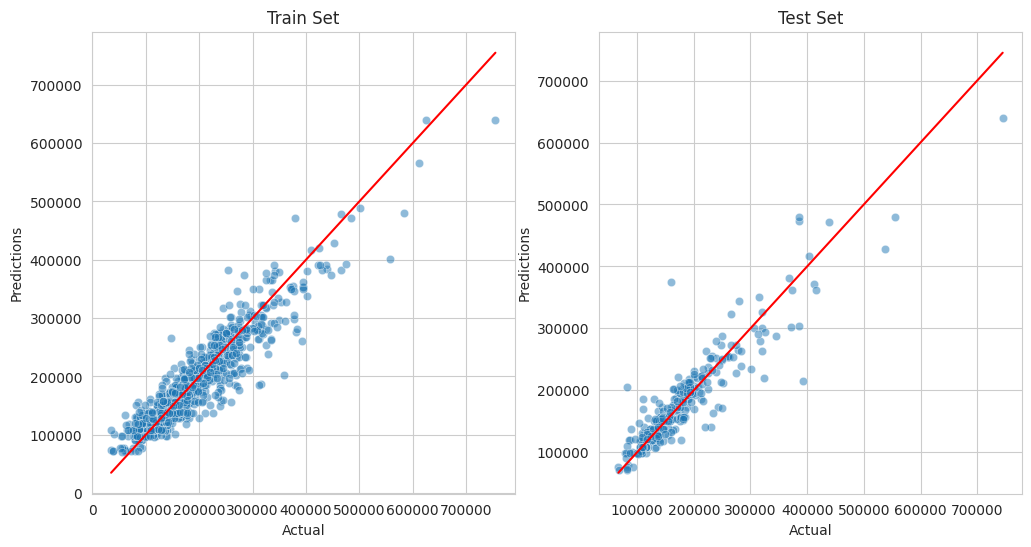

In [35]:
regression_performance(X_train, y_train, X_test, y_test,best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test,
                            best_regressor_pipeline)

## Comparing both plots and results shows an improvement in model performance for PCA

- **PCA pipeline has less extreme outliers in the scatter plot**

- **PCA pipeline has minor drop in the R2 score for the test set**

- **PCA pipeline has a smaller jump in error values for the test set than compared to LinearRegression Pipeline**

<hr>

- *Regression Plots*

![RegressionPlot](images/analysis-images/Regression-train-test-plots.png)

<hr>

<hr>

- *Regression Scores* 

![RegressionScores](images/analysis-images/Linear-Regression-Best-Results.png)

<hr>

<hr>

- *PCA (GBR) Plots* 

![PCA (GBR )Plot](images/analysis-images/GBR-train-test-plots.png)

<hr>

<hr>

- *PCA (GBR) Scores*

![PCA (GBR) Scores](images/analysis-images/GBR-best-results.png)

<hr>


##### Conclusion at this point:

- PCA pipline is performing to the business requirements, where the R2 score is above 0.8 for both the train and test sets.

In [36]:
best_regressor_pipeline

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['BsmtExposure', 'BsmtFinType1',
                                           'GarageFinish', 'KitchenQual'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(selection_method='variance',
                                          threshold=0.7,
                                          variables=['1stFlrSF', '2ndFlrSF',
                                                     'BedroomAbvGr',
                                                     'BsmtExposure',
                                                     'BsmtFinSF1',
                                                     'BsmtFinType1',
                                                     'Bs...rea',
                                                     'GarageFinish',
                                                     'GarageYrBlt', 'GrLivArea',
  

In [37]:
models_search

{'GradientBoostingRegressor': GradientBoostingRegressor(random_state=0)}

In [38]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__learning_rate': 0.1,
 'model__max_depth': 3,
 'model__max_leaf_nodes': None,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 50,
 'model__n_estimators': 50}

In [39]:
deploy_pipeline = grid_search_pipelines[best_model].best_estimator_

deploy_pipeline

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['BsmtExposure', 'BsmtFinType1',
                                           'GarageFinish', 'KitchenQual'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(selection_method='variance',
                                          threshold=0.7,
                                          variables=['1stFlrSF', '2ndFlrSF',
                                                     'BedroomAbvGr',
                                                     'BsmtExposure',
                                                     'BsmtFinSF1',
                                                     'BsmtFinType1',
                                                     'Bs...rea',
                                                     'GarageFinish',
                                                     'GarageYrBlt', 'GrLivArea',
  

# Push files to Repo

In [40]:
import joblib
import os

version = 'v1'
file_path = f'outputs/ml_pipeline/predict_sale_price/{version}'

try:
  os.makedirs(name=file_path)
except Exception as e:
  print(e)

[Errno 17] File exists: 'outputs/ml_pipeline/predict_sale_price/v1'


In [41]:
joblib.dump(value=deploy_pipeline, filename=f"{file_path}/deploy_pca_pipeline.pkl")

['outputs/ml_pipeline/predict_sale_price/v1/deploy_pca_pipeline.pkl']

In [42]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

In [43]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

In [44]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)


In [45]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)